In [44]:
import numpy as np
np.random.seed(123)

import matplotlib.pyplot as plt
import matplotlib as mpl
import multiprocessing as mp
from dataclasses import dataclass
from astropy import units as u
from astropy.coordinates import SkyCoord, Galactocentric

from orbits.integrator import getPeriApoTime, getInjectionCoords, leapfrog

In [45]:
gc_frame = Galactocentric(
    galcen_distance = 8.29*u.kpc,
    z_sun=0*u.pc,
    galcen_v_sun = [11.1, 240.3+12.24, 7.25] * (u.km/u.s)
)

In [46]:
@dataclass
class dwarf_obs:
    ra: float
    dec: float
    
    distance: float
    pm_ra: float
    pm_dec: float
    radial_velocity: float
    
    distance_err: float = 0
    pm_ra_err: float = 0
    pm_dec_err: float = 0
    radial_velocity_err: float = 0

In [99]:
coord = SkyCoord(x=[1,2,3]*u.kpc, y=[1,2,3]*u.kpc, z=[1,2,3]*u.kpc, frame=gc_frame)

In [100]:
coord.transform_to("icrs")

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    [(264.24004929, -20.5062059 ,  9.39702613),
     (262.72360074, -13.95034073, 10.67164936),
     (261.60370472,  -8.8406695 , 12.06084989)]>

In [ ]:
SkyCoord(x =1, y=1, z=1, frame=gc_frame).transform_to

In [47]:
class dwarf_phase:
    def __init__(self, x, y, z, v_x, v_y, v_z):
        self.x = x
        self.y = y 
        self.z = z
        self.v_x = v_x
        self.v_y = v_y
        self.v_z = v_z
    
    @property
    def v(self):
        return [self.v_x, self.v_y, self.v_z]
    
    @property 
    def pos(self):
        return [self.x, self.y, self.z]
    
    def __str__(self):
        s = "["
        s += f"{self.x:0.2f}, "
        s += f"{self.y:0.2f}, "
        s += f"{self.z:0.2f}"
        s += "]kpc, \t["
        s += f"{self.v_x:0.4f}, "
        s += f"{self.v_y:0.4f}, "
        s += f"{self.v_z:0.4f}"
        s += "] km/s"
        return s
        
    def __repr__(self):
        return str(self)

In [23]:
def to_galcen(obs):
    sc = SkyCoord(ra = obs.ra * u.deg,
                  dec=obs.dec * u.deg,
                  distance = obs.distance * u.kpc,
                  radial_velocity = obs.radial_velocity * u.km/u.s,
                  pm_ra_cosdec = obs.pm_ra * u.mas/u.yr,
                  pm_dec = obs.pm_dec * u.mas/u.yr
                 )
    tc = sc.transform_to(gc_frame)
    x, y, z = [tc.x, tc.y, tc.z]
    vx, vy, vz = [tc.v_x, tc.v_y, tc.v_z]
    x /= u.kpc
    y /= u.kpc
    z /= u.kpc
    vx /= u.km/u.s
    vy /= u.km/u.s
    vz /= u.km/u.s
 
    return dwarf_phase(x, y, z, vx, vy, vz)

In [24]:
def rand_coords(obs, N):
    ra = np.full(N, obs.ra)
    dec = np.full(N, obs.dec)
    distance = np.random.normal(obs.distance,obs.distance_err, N)
    pm_ra = np.random.normal(obs.pm_ra,obs.pm_ra_err, N)
    pm_dec = np.random.normal(obs.pm_dec,obs.pm_dec_err, N)
    radial_velocity = np.random.normal(obs.radial_velocity,obs.radial_velocity_err, N)
    X = np.array([ra, dec, distance, pm_ra, pm_dec, radial_velocity])
    rand_obs = [dwarf_obs(*x) for x in X.transpose()]
    return rand_obs

In [59]:
def periApoHist(coords):
    periSet = np.array([])
    apoSet = np.array([])
    coordSet = []

    # print('multiprocessing...',end='\r')
    # pool = mp.Pool(nCores)
    # results = np.array(pool.map(helper, coords))
    # pool.close()
    # print('done multiprocessing')
    N = len(coords)
    peris = np.empty(N)
    apos = np.empty(N)
    filt = np.full(N, False)
    for i  in range(N):
        pc = to_galcen(coords[i])
        x = [pc.x, pc.y, pc.z]
        v = [pc.v_x, pc.v_y, pc.v_z]
        peri, apo, _ = getPeriApoTime(-4e9, -1e6, x, v)
        peris[i] = peri
        apos[i] = apo
        if peri is None or apo is None:
            continue
        if peri > 0 and apo > 0:
            filt[i] = True
            coordSet.append(pc)

    periSet = peris[filt]
    apoSet = apos[filt]
    return periSet,apoSet,filt


In [52]:
fornax_radec = SkyCoord(ra="2h39m59.3s", dec="-34d26m57s")

fornax_obs = dwarf_obs(
    ra = fornax_radec.ra/u.deg,
    dec = fornax_radec.dec/u.deg,
    distance = 147,
    distance_err = 12,
    pm_ra = 0.374 ,
    pm_ra_err = 0.035 ,
    pm_dec = -0.401,
    pm_dec_err = 0.035,
    radial_velocity = 55.3,
    radial_velocity_err = 0.3
)

craterii_obs = dwarf_obs(
    ra = 177.3,
    dec = -18.4,
    distance=117.5,
    distance_err = 1.1,
    pm_ra = -0.246, 
    pm_ra_err = 0.052,
    pm_dec = -0.227,
    pm_dec_err = 0.026,
    radial_velocity = 87.5,
    radial_velocity_err = 0.4
)

In [62]:
mc_obs = rand_coords(fornax_obs, 100)
peris, apos, filt = periApoHist(mc_obs)

In [64]:
mc_coords = []
good_obs = []
for i in range(len(filt)):
    if filt[i]:
        obs = mc_obs[i]
        good_obs.append(obs)
        mc_coords.append(to_galcen(obs))

Text(0, 0.5, 'apocenter')

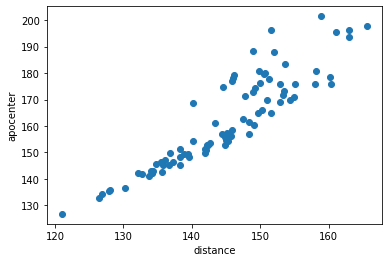

In [69]:
plt.scatter([o.distance for o in good_obs], apos)
plt.xlabel("distance")
plt.ylabel("apocenter")

In [71]:
percentiles = [16, 84]

present = {}

present["50"] = to_galcen(fornax_obs)

for per in percentiles:
    idx = np.argsort(peris)[int((len(peris) - 1) * per/100)]
    present[str(per)] = mc_coords[idx]


In [78]:
past = {}
apo_times = {}
for per, coord in present.items():
    x = [coord.x, coord.y, coord.z]
    v = [coord.v_x, coord.v_y, coord.v_z]
    x2, v2, apo_time = getInjectionCoords(x, v, 10, physicalUnits=True)
    past[per] = dwarf_phase(*x2, *v2)
    apo_times[per] = apo_time

In [79]:
present

{'50': [-41.21, -50.89, -133.93]kpc, 	[40.3986, -124.9545, 82.7880] km/s,
 '16': [-38.34, -46.46, -122.27]kpc, 	[27.1201, -86.2094, 71.7363] km/s,
 '84': [-40.97, -50.52, -132.95]kpc, 	[55.7842, -144.3232, 86.1833] km/s}

In [80]:
past

{'50': [31.57, 102.59, 122.76]kpc, 	[-37.8505, 105.2257, -78.1885] km/s,
 '16': [-44.02, -7.84, -135.08]kpc, 	[7.6355, -102.3527, 3.4242] km/s,
 '84': [42.69, -167.29, 38.24]kpc, 	[41.7971, 40.7130, 131.5140] km/s}

Code unit conversion

In [84]:
np.array(past["50"].v) / 207.4

array([-0.18249986,  0.50735613, -0.37699394])

In [121]:
phase = present["50"]

In [123]:
import lilguys

In [127]:
sc = lilguys.coords.to_skycoord(phase)

In [133]:
sc.pm_dec

<Quantity -0.401 mas / yr>

In [126]:
fornax_radec

<SkyCoord (ICRS): (ra, dec) in deg
    (39.99708333, -34.44916667)>

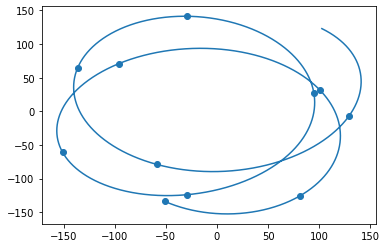

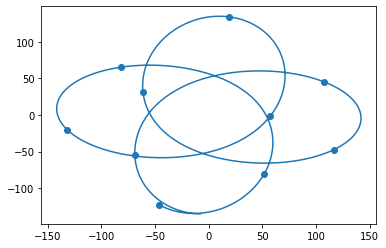

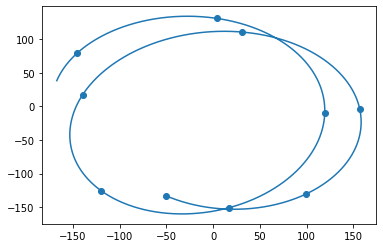

In [91]:
for per, coord in present.items():
    x = [coord.x, coord.y, coord.z]
    v = [coord.v_x, coord.v_y, coord.v_z]
    apo_time = apo_times[per]
    [xs, ys, zs, rs], vs = leapfrog(apo_time, -1e6, x, v)
    plt.plot(ys, zs)
    idxs = np.arange(0, len(xs), 1000) # 1e9 when accounting for timestep
    plt.scatter(np.array(ys)[idxs], np.array(zs)[idxs])
    plt.show()